## Building multilayer Neural network model from scratch using Python
Let us consider a supervised learning problem where X is a training example with n features. These features are usually known as inputs in neural network and form a first layer of the the network. y (k dimensional vector) corresponds to label of each training example and belongs to any of k classes depending on its element. For example y={1,0,0,0} belongs to class 1 with possible 4 classes. y forms the final layer of the network. In vectorized notation X and y are represented by matrices of sizes m x n and m x k respectively, where m is the total number of examples (data points/ observations). 

In a fully connected neural network neurons of each layer share all of the neurons on the preceeding layer. In other words, outputs (usually called activations) of a layer become inputs to the next layer. A figure shown below represents a neural network with two hidden layers. 



![img](http://cs231n.github.io/assets/nn1/neural_net2.jpeg)
Source ([http://cs231n.github.io/neural-networks-1/])

### Training the network
 

#### Steps:

#### Forward propogation:<br>
In the above figure hidden layer 1 is connected to the input layer with weights $W^{1}$ and bias $b^{1}$. Here $W^{1}$ is a matrix of size n x h1 (n=3, h1=4) and $b{1}$ is vector of length (h1=4). Similary $W^{2}$ and $b^{2}$ of sizes h1 x h2 (=4x4) and h2 (=4) connects hidden layer 1 to hidden layer 2. Finally $W^{3}$ and $b^{3}$ of sizes h2 x k (=4x1) and k (=1) connect hidden layer 2 with output layer. In general we have:<br>

$z^{l+1} = (W^{l})^{T}a^{l} + b^{l}$ <br>
$a^{l} = sigmod(z^{l})$ <br>

$sigmoid(p) = \frac{1}{1+e^{-p}}$ <br>

$a^{1} = input$

output:<br>
$a^{n_{l}} = softmax(z^{n_{l}})$ <br>

$softmax(p_{i}) = \frac{e^{p_{i}}}{\sum e^{p_{i}}} $


#### Cost Function: (m examples and k outputs)<br>
$J = - \frac{1}{m} \sum_{m} \sum_{i} y_{i}.log(y^{'}_{i}) $ <br>

$y^{'}=a^{n_{l}}$ is the predicted output i.e. softmax($z^{n_{l}}$) in this case. <br>

For output layer:
$\delta^{n_{l}} = (a^{n_{l}}_{i}-y_{i})$


#### Back propagation:<br>
Backpropagation is used to efficiently compute the gradient of the cost function with respect to each weight and bias. <br>
output layer:<br>
$\frac{\partial J}{\partial z^{n_{l}}} = \delta ^{n_{l}} = (a^{n_{l}}-y)$  

hidden layer:<br>
$\delta ^{l} = (W^{l})^{T}\delta ^{l+1} \odot f'(z^{l}) $ <br>

$\odot $represents item wise product

$\frac{\partial J}{\partial W^{l}} = (a^{l})^{T} \delta^{l+1} $ <br>
$\frac{\partial J}{\partial b^{l}} = \sum^{m} \delta^{l+1} $


#### Updates:<br>
After we have all the required elements (gradient of J), we update corresponding element as <br>
$W^{l} = W^{l} - \alpha \frac{\partial J}{\partial W^{l}}$ <br>
$b^{l} = b^{l} - \alpha \frac{\partial J}{\partial b^{l}}$


Details of explanation can be found <a href='http://ufldl.stanford.edu/tutorial/supervised/MultiLayerNeuralNetworks/'>here</a>. <br>
Let's jump into the coding :

In [149]:
import numpy as np
# sigmoid function for activation
def sigmoid(t):
    sig_t = 1./(1.+np.exp(-t)) 
    return sig_t, sig_t*(1.-sig_t)  # sigmoid and derivative

#used for final output
def softmax(t):
    t = np.exp(t)
    soft_t = t/(np.sum(t, axis=1).reshape((len(t),1)))
    return soft_t

#computing forward propagation
def forward_prop(x_data, model):
    l_ = len(model) #total coefficient matrices one + hidden layers
    a ={0:x_data}
    da = {}  #derivative of activation
    for i in range(l_-1):
        z = a[i].dot(model[i]['W']) + model[i]['b']
        a[i+1],da[i+1] = sigmoid(z)
    z = a[l_-1].dot(model[l_-1]['W']) + model[l_-1]['b']
    a[l_]= softmax(z)
    return a , da
    
#Prediction
def predict(x_data, model):
    a_ , _= forward_prop(x_data, model)
    return np.argmax(a_[len(a_)-1], axis=1)

#Accuracy
def accuracy(x_data, y_data, model):
    y_ = predict(x_data, model)
    correct = abs(y_-np.argmax(y_data, axis=1))
    return (1.-np.average(correct))*100.

#Error function
def loss(y_, y):
    c_ = -1.*y*np.log(y_)
    c_ = np.sum(c_, axis=1)
    return np.average(c_)

#Fitting the model
def fit(data, target, h, epoch, eps, reg, decay=0.0, print_loss=False):
    np.random.seed(0)
    layers = np.array([data.shape[1]]+h+[target.shape[1]])
    coeff_orders=[]
    for l in range(len(layers)-1):
        coeff_orders.append((layers[l],layers[l+1]))
    parameters = {}
    for c in range(len(coeff_orders)):
        size = coeff_orders[c]
        W = np.random.randn(size[0],size[1])
        b = np.random.randn(1, size[1])
        parameters[c]={'W':W, 'b':b}
    
    iterations =[]
    error = []
    for steps in range(epoch):
        alpha = eps*np.exp(-float(steps)*decay)
        
        #forward prop
        a, da = forward_prop(data, parameters)
        fac = int(epoch/20)
        if steps % fac == 0:
            iterations.append(steps)
            error.append(loss(a[len(a)-1], target))
            if print_loss:
                print('Steps %d, error: %g'%(steps, loss(a[len(a)-1], target)))
            
        l_ = len(a)-1
        delta_of_output_layer = a[l_]-target
        #print(delta_of_output_layer.shape)
        delta ={l_:delta_of_output_layer}
        #print(delta)
        db = {}
        dw = {}
        #db[l_-1] = np.sum(delta_output_layer).reshape((1,delta_output_layer.shape[1]))
        #print(l_)
        for d_ in range(1,l_):
            back_d = len(h)-d_+1
            db[back_d] = np.sum(delta[back_d+1], axis=0).reshape((1,delta[back_d+1].shape[1]))
            dw[back_d] = ((a[back_d]).T).dot(delta[back_d+1])
            dw[back_d]+= reg*parameters[back_d]['W']
            #print(dW)
            #print(delta)
            delta[back_d]=delta[back_d+1].dot((parameters[back_d]['W']).T)*da[back_d]
            #print(da[back_d].shape)
        #print(delta)
        dw[0]=(data.T).dot(delta[1])
        dw[0]+=reg*parameters[0]['W']
        db[0]=np.sum(delta[1], axis=0).reshape((1,delta[1].shape[1]))
        
        for param in range(len(parameters)):
            parameters[param]['W']-=alpha*dw[param]
            parameters[param]['b']-=alpha*db[param]
            
    return parameters, iterations, error

#Plotting decision boundary
def plot_decision_boundary(X,y,model):
    minx1, maxx1 = min(X[:,0])-0.2*abs(min(X[:,0])), max(X[:,0])+0.2*abs(max(X[:,0]))
    minx2, maxx2 = min(X[:,1])-0.2*abs(min(X[:,1])), max(X[:,1])+0.2*abs(max(X[:,1]))
    x1 = np.linspace(minx1, maxx1, 200)
    x2 = np.linspace(minx2, maxx2, 200)
    x1, x2 = np.meshgrid(x1,x2)
    x = np.column_stack((x1.flatten(),x2.flatten()))
    z = predict(x,model)
    z = z.reshape((200,200))

    fig = plt.figure(figsize=(5,5))
    plt.contourf(x1,x2,z, cmap=plt.cm.seismic, alpha=0.2)
    plt.scatter(X[:,0], X[:,1], s=40, c=np.argmax(y, axis=1), cmap=plt.cm.spring)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title(str(len(model)-1)+' hidden layer(s)') 
    plt.xlim(minx1, maxx1)
    plt.ylim(minx2, maxx2)
    plt.show()

#plotting error (cost)
def plot_error(epochs, cost):
    plt.plot(epochs[2:], cost[2:], 'ro-')
    plt.xlabel('iteration')
    plt.ylabel('Loss')
    plt.title('Error Plot')
    plt.show()    
    

### Test with a data set

In [129]:
import numpy as np
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
np.random.seed(0)
X, y = datasets.make_moons(300, noise=0.15)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=7)

#plt.scatter(X[:,0], X[:,1], s=40, c=y, cap=plt.cm.seismic
#plt.show()
train_y = pd.get_dummies(train_y).values
test_y = pd.get_dummies(test_y).values

n_hidden =[5,2,3]  #hidden layers with node on each layer must be a list
n_steps = 20000    #total number of steps
eps = 0.001        # learning rate
reg = 0.0          #regularization

model, epochs, cost =  fit(train_X, train_y, n_hidden, n_steps, eps, reg, decay=0.0, print_loss=True) #decay= decay constant


Steps 0, error: 1.74947
Steps 1000, error: 0.29864
Steps 2000, error: 0.0600528
Steps 3000, error: 0.031034
Steps 4000, error: 0.0256049
Steps 5000, error: 0.0236125
Steps 6000, error: 0.0226513
Steps 7000, error: 0.0221006
Steps 8000, error: 0.0217433
Steps 9000, error: 0.0214888
Steps 10000, error: 0.0212941
Steps 11000, error: 0.0211369
Steps 12000, error: 0.0210046
Steps 13000, error: 0.02089
Steps 14000, error: 0.0207884
Steps 15000, error: 0.0206968
Steps 16000, error: 0.0206134
Steps 17000, error: 0.0205367
Steps 18000, error: 0.0204658
Steps 19000, error: 0.0203999


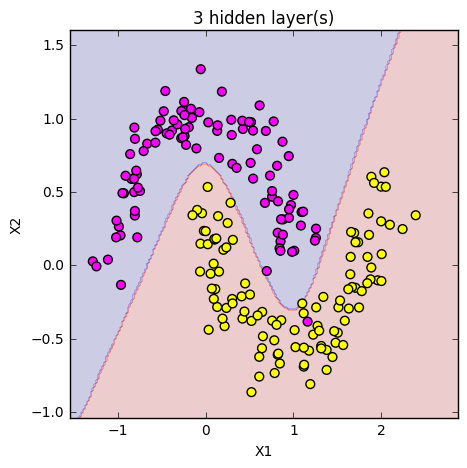

In [130]:
plot_decision_boundary(train_X,train_y,model)

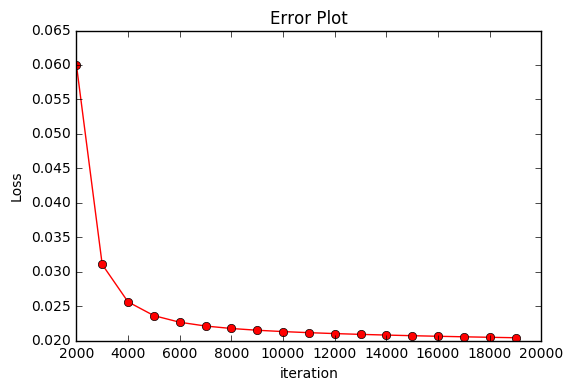

In [131]:
plot_error(epochs,cost)

In [132]:
print('Accuracy on train set:  {:.2f} %'.format(accuracy(train_X, train_y, model)))
print('Accuracy on test set:  {:.2f} %'.format(accuracy(test_X, test_y, model)))

Accuracy on train set:  99.52 %
Accuracy on test set:  98.89 %


### Test on more data
Following two data sets are taken from coursera machine learning course by Andrew Ng. <br>

#### Data set 1


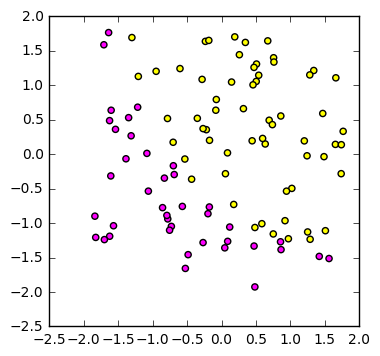

In [133]:
data3 = pd.read_csv('ex2data1.txt', header=None)
train_X = data3[[0,1]].values
mu = np.average(train_X, axis=0)
sig = np.std(train_X, axis=0)
train_X-=mu
train_X/=sig

train_y = pd.get_dummies(data3[2]).values

#Plot the data
fig = plt.figure(figsize=(4,4))
plt.scatter(train_X[:,0],train_X[:,1], s=20, c=data3[2].values, cmap=plt.cm.spring)
plt.show()

In [134]:
n_hidden =[5]
n_steps = 10000
eps = 0.005
reg = 0.01

model, epochs, cost =  fit(train_X, train_y, n_hidden, n_steps, eps, reg) #, decay=0.0, print_loss=False)

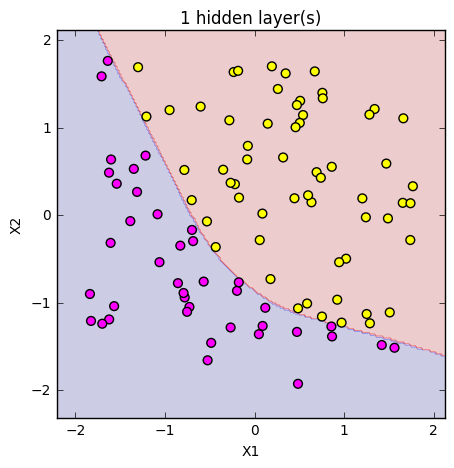

In [135]:
plot_decision_boundary(train_X, train_y, model)
#plot_error(epochs,cost)

In [136]:
print('Accuracy on train set:  {:.2f} %'.format(accuracy(train_X, train_y, model)))

Accuracy on train set:  100.00 %


#### Data set 2

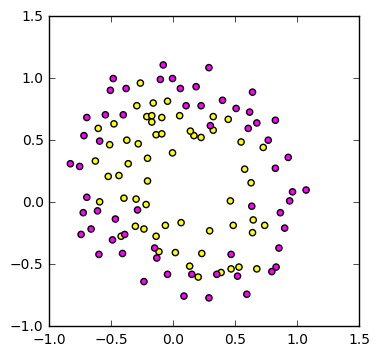

In [137]:
data2 = pd.read_csv('ex2data2.txt', header=None)
data2.head(2)
train_X = data2[[0,1]].values
train_y = pd.get_dummies(data2[2]).values
#Plot the data
fig = plt.figure(figsize=(4,4))
plt.scatter(train_X[:,0],train_X[:,1], s=20, c=data2[2].values, cmap=plt.cm.spring)
plt.show()

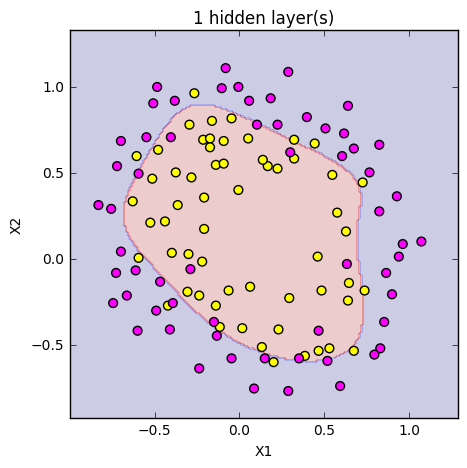

In [138]:
n_hidden =[55]
n_steps = 50000
eps = 0.0005
reg = 0.0

model, epochs, cost =  fit(train_X, train_y, n_hidden, n_steps, eps, reg, decay=0.0, print_loss=False)

plot_decision_boundary(train_X, train_y, model)
#plot_error(epochs,cost)

In [139]:
print('Accuracy on train set:  {:.2f} %'.format(accuracy(train_X, train_y, model)))

Accuracy on train set:  83.90 %


##### Let's try with more layers

In [143]:
train_X = data2[[0,1]].values
train_y = pd.get_dummies(data2[2]).values

n_hidden =[105,55,35]
n_steps = 50000
eps = 0.0005
reg = 0.0

model, epochs, cost =  fit(train_X, train_y, n_hidden, n_steps, eps, reg) #, decay=0.0, print_loss=True)


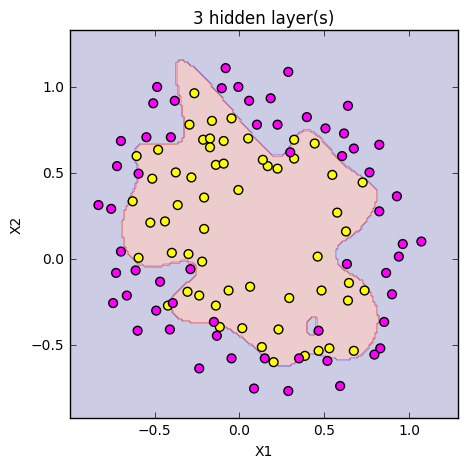

In [144]:
plot_decision_boundary(train_X,train_y, model)

In [145]:
print('Accuracy on train set:  {:.2f} %'.format(accuracy(train_X, train_y, model)))

Accuracy on train set:  93.22 %
